In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx 
import networkit as nk

# Workflow overview for calculating closeness centralities for FAT10 in full length

## Loading the topology
For the calculation of the closeness centralities, the frames from the simulation trajectories first need to be loaded. Because of the size of the data, this is done interatively by calling md.iterload() in the processing later on. To do this, the total number of frames of the trajectory needs to be set here as well as the size of chunks in which it should be loaded.  See https://mdtraj.org/1.9.4/api/generated/mdtraj.iterload.html for more information. 

In [2]:
topology_file = "./start_frame_FAT10.pdb"
traj_file = "./FAT10_123_traj_center_dt100.xtc"
topology = md.load(topology_file)
n_frames = 300150 # Total number of frames in the trajectory. Here, this needs to be defined to be able to load the trajecory iteratively. Can also be inferred via traj.n_frames for smaller trajs. 
chunksize = 2001 # Number of frames to load into memory at a time. Here, this is the size of an individual trajectory. This can be optimized based on computational constraints. 
n_residues = topology.n_residues

## Setting distance thresholds for network construction

In [3]:
thresh_low = 0.0  # Excluding values that are 0 based on the distance calculation.
thresh_high = 0.45 # in nanometers. This is a free parameter in the workflow and should be selected based on the task.

## Constructing an adjacency matrix, in which direct neighbors in the backbone are connected to add to the distance-based adjacency matrices later. 
The closeness centrality can only be calculated meaningfully for connected graphs, since it is based on the shortest path lengths in the graph, which are undefined in the case of unconnected graphs. 
This is why we fix the backbone of the protein to be connected based on the protein sequence (i.e. covalent interactions). 

In [4]:
connected_backbone = np.zeros((chunksize, n_residues, n_residues))
for frame in range(connected_backbone.shape[0]):
    for i in range(connected_backbone.shape[1]-1):
        connected_backbone[frame, i, i+1] = 1
        connected_backbone[frame, i+1, i] = 1

## Calculating the closeness centralities


The calculation of the closeness centralities is broken down into several steps:
### Loading the trajectory iteratively 

uses `mdtraj.iterload()` https://mdtraj.org/1.9.4/api/generated/mdtraj.iterload.html

It is also possible to load the full trajectory depending on the available memory. 

### Calculating the pairwise distances between residues. 

Here, this is done using the function `mdtraj.compute_contacts()`, which calculates the distances for all pairs of residues separated by two or more residues. Here the sidechain distances are calculated. Other schemes, such as C-alpha distance ('CA' or minimum distance ('closest') exist. Please refer to the function documentation for more details: https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_contacts.html 
The list of distances is the transformed into a distance matrix for the graph construction with consistent node indices. Constructing the graph from an edge list can lead to inconsistent node indices depending on the connectivity.  

### Calculating adjacency matrices for each trajectory frame 

The boolean (0 or 1) adjacency matrix is calculated based on the thresholds set above using `numpy.logical_and()`. The backbone connections are added in matrix form to ensure a connected graph. 

### Translating the adjacency matrices into graphs 

To translate the adjacency matrix into a graph, the function `networkx.to_networkx_graph()` from the package NetworkX https://networkx.org/documentation/stable/reference/generated/networkx.convert.to_networkx_graph.html. 

This is subsequently translated into a NetworKit graph using `networkit.nxadapter.nx2nk()`. This is done because NetworKit has optimized routines for calculating centralities, but no own graph constructor for adjacency matrices. https://networkit.github.io/dev-docs/python_api/nxadapter.html

### Calculation of closeness centralities 

From the networkit graph (`nkG`), the closeness centralities are the calculated using `networkit.centrality.Closeness()`. This highly optmized function is substantially faster than its NetworkX equivalent, since it is implemented in C++ rather than pure Python. This makes the calculation of the closeness centralities computationally tractable also for a large number of frames (in the order of seconds/minutes vs. days/weeks, depending on system size). For very large systems, approximate versions of centrality calculations are available. 
The centralities are normalized to be in an interval of [0.1] by setting the parameter `normalized` to `True`. The parameter `ClosenessVariant.Standard`  means it uses the standard definition of closeness, that is defined for connected graphs only.  This automatically checks the graph for connectedness. A `generalized` version of the centrality calculation considers the connected components of the graphs separately and can thus also work for unconnected graphs. Please refer to the documentation for further details https://networkit.github.io/dev-docs/python_api/centrality.html

In [5]:
closeness = np.zeros((n_frames,n_residues))
for chunk_id, chunk in tqdm(enumerate(md.iterload(traj_file, top = topology, chunk = chunksize))):
    
    # Calculate pairwise distances between residues 
    distances, residue_pairs =  md.compute_contacts(chunk, scheme = 'sidechain')
    
    # Transform distances into matrix format to construct adjacency matrices 
    distance_matrices = md.geometry.squareform(distances, residue_pairs)
    
    # Convert distances into contact bool based on thesholds
    adjacency_matrices = np.logical_and(distance_matrices > thresh_low, 
                                        distance_matrices< thresh_high)
    
    # Add covalent backbone to the graph to ensure connectedness 
    adjacency_matrices = adjacency_matrices + connected_backbone
    
    for frame in range(chunksize): 
        # construct a NetworKit graph (nkG) from an adjacency matrix
        nxG = nx.to_networkx_graph(adjacency_matrices[frame])
        nkG = nk.nxadapter.nx2nk(nxG) 
        
        # Calculate closeness centralities 
        closeness_calculation = nk.centrality.Closeness(nkG, 
                                                        True, # normalized (bool) 
                                                        nk.centrality.ClosenessVariant.Standard)
        closeness_centrality_scores = closeness_calculation.run().scores()
        
        closeness[frame + chunksize*chunk_id] = np.asarray(closeness_centrality_scores)

150it [4:35:34, 110.23s/it]


In [6]:
np.save("Closeness_Centralities_full_length_FAT10", closeness)

## Plotting the closeness centrality fingerprint for an individual trajectory

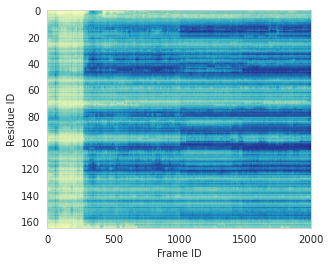

In [7]:
%matplotlib inline
plt.imshow(closeness[0:2001].T, 
           aspect = 10,
           cmap= "YlGnBu")
plt.xlabel("Frame ID")
plt.ylabel("Residue ID")
plt.grid(False)